In [1]:
11

11

## packages

In [2]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestRegressor

In [3]:
from google.colab import drive
drive.mount('/content/mydrive/')

Drive already mounted at /content/mydrive/; to attempt to forcibly remount, call drive.mount("/content/mydrive/", force_remount=True).


## csvs

In [4]:
train = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/train.csv')
train.head(1)

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
0,2018-01-01,NaN,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950


In [5]:
test = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/test.csv')
test.head(1)

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max
0,2021-01-01,NaN,-4.2,1.6,-9.8,30.0,17.0,64.0,6.5,67.7,2.0,4.1


In [6]:
# 프로젝트의 목표 : 따릉이 대여량 예측
submission = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/sample_submission.csv')
submission.head(1)

,date,rental
0,2021-01-01,0


## preprocessing



In [7]:
# train set

# 1 
train['rental'] = train['rental'].astype(float)


# 2 
def extract_year_from_date(text:str):
    return int(text[:4])
train['year'] = train['date'].map(extract_year_from_date)



# 3 
def extract_month_from_date(text:str):
    return int(text[5:7])
train['month'] = train['date'].map(extract_month_from_date)


# 4
def extract_day_from_date(text:str):
    return int(text[-2:])

train['day'] = train['date'].map(extract_day_from_date)

# 5
train.dropna(axis=0, subset=['PM10', 'PM2.5'], inplace=True)

# 6, 7
imp_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
imputed_train = pd.DataFrame(imp_zero.fit_transform(train.select_dtypes(exclude=['object'])))
imputed_train.columns = ['precipitation',
                         'temp_mean',
                         'temp_highest',
                         'temp_lowest',
                         'PM10',
                         'PM2.5',
                         'humidity',
                         'sunshine_sum',
                         'sunshine_rate',
                         'wind_mean',
                         'wind_max',
                         'rental',
                         'year',
                         'month', 
                         'day']


# 8
imputed_train['year'] = imputed_train['year'].astype(int)
imputed_train['month'] = imputed_train['month'].astype(int)
imputed_train['day'] = imputed_train['day'].astype(int)

# 9
train = imputed_train

In [8]:
# test set

# 1
test['year'] = test['date'].map(extract_year_from_date)


# 2
test['month'] = test['date'].map(extract_month_from_date)


# 3
test['day'] = test['date'].map(extract_day_from_date)

# 4, 5
imputed_test = pd.DataFrame(imp_zero.fit_transform(test.select_dtypes(exclude=['object'])))
imputed_test.columns = ['precipitation',
                         'temp_mean',
                         'temp_highest',
                         'temp_lowest',
                         'PM10',
                         'PM2.5',
                         'humidity',
                         'sunshine_sum',
                         'sunshine_rate',
                         'wind_mean',
                         'wind_max',
                         'year',
                         'month', 
                         'day']


# 6
imputed_test['year'] = imputed_test['year'].astype(int)
imputed_test['month'] = imputed_test['month'].astype(int)
imputed_test['day'] = imputed_test['day'].astype(int)


# 7
test = imputed_test

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  1026 non-null   float64
 1   temp_mean      1026 non-null   float64
 2   temp_highest   1026 non-null   float64
 3   temp_lowest    1026 non-null   float64
 4   PM10           1026 non-null   float64
 5   PM2.5          1026 non-null   float64
 6   humidity       1026 non-null   float64
 7   sunshine_sum   1026 non-null   float64
 8   sunshine_rate  1026 non-null   float64
 9   wind_mean      1026 non-null   float64
 10  wind_max       1026 non-null   float64
 11  rental         1026 non-null   float64
 12  year           1026 non-null   int64  
 13  month          1026 non-null   int64  
 14  day            1026 non-null   int64  
dtypes: float64(12), int64(3)
memory usage: 120.4 KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  365 non-null    float64
 1   temp_mean      365 non-null    float64
 2   temp_highest   365 non-null    float64
 3   temp_lowest    365 non-null    float64
 4   PM10           365 non-null    float64
 5   PM2.5          365 non-null    float64
 6   humidity       365 non-null    float64
 7   sunshine_sum   365 non-null    float64
 8   sunshine_rate  365 non-null    float64
 9   wind_mean      365 non-null    float64
 10  wind_max       365 non-null    float64
 11  year           365 non-null    int64  
 12  month          365 non-null    int64  
 13  day            365 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 40.0 KB


## validation model

In [11]:
# Obtain target and predictors
y = train.rental
X = train.drop('rental', axis=1)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y,
                                                      train_size=0.8,
                                                      test_size=0.2,
                                                      random_state=0,
                                                      shuffle=True)

In [13]:
# validation model은 shuffle=True인 X_train을 학습했다.
# test model도 train을 shuffle=True로 학습시키면 성능이 향상될지 안될지 궁금하다.
# 성능 향상 여부를 확인해보기 위해 sklearn.utils에서 shuffle을 import한다.
X_train.head(3)

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,year,month,day
204,0.0,22.0,26.5,17.7,31.0,16.0,59.8,7.9,64.2,1.2,3.4,2018,9,18
363,0.0,4.7,10.2,1.3,78.0,57.0,55.8,8.0,71.4,2.3,4.8,2019,2,25
5,0.0,-2.8,2.9,-6.8,38.0,27.0,45.8,8.8,90.7,1.5,3.1,2018,1,6


In [14]:
validation_model= RandomForestRegressor(n_estimators=100, random_state=0)
validation_model.fit(X_train, y_train)
preds = validation_model.predict(X_valid)
mae = mean_absolute_error(y_valid, preds)
print('MAE : ', mae)

MAE :  5554.791990291262


## test model

In [15]:
# train은 shuffle=False인 상태이다.
train.head(3)

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day
0,0.0,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950.0,2018,1,1
1,0.0,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136.0,2018,1,2
2,0.0,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156.0,2018,1,3


In [16]:
# shuffle()을 사용해서 train도 shuffle=True인 상태로 test model을 학습시켜보자.
train = shuffle(train)
train.head(3)

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day
360,0.0,4.0,10.8,-1.6,65.0,49.0,56.1,9.5,85.6,1.5,3.7,21727.0,2019,2,22
471,0.0,22.7,27.8,19.8,24.0,16.0,70.6,6.9,46.6,1.9,4.2,88226.0,2019,6,20
557,0.0,21.0,25.4,16.0,29.0,13.0,46.0,11.7,94.4,3.1,4.9,92045.0,2019,9,18


In [17]:
# shuffle=True인 train을 predictor와 target으로 나눈다.
y = train.rental
X = train.drop('rental', axis=1)

In [18]:
test_model = RandomForestRegressor(n_estimators=100, random_state=0)
test_model.fit(X, y)
submission['rental'] = test_model.predict(test)

In [19]:
submission.to_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/submission-2022-06-14-ik.csv', index=False)

## submission result
- test model도 train을 shuffle=True로 학습시키면 성능이 향상된다.
- first one : shuffle=True
- second one : shuffle=False

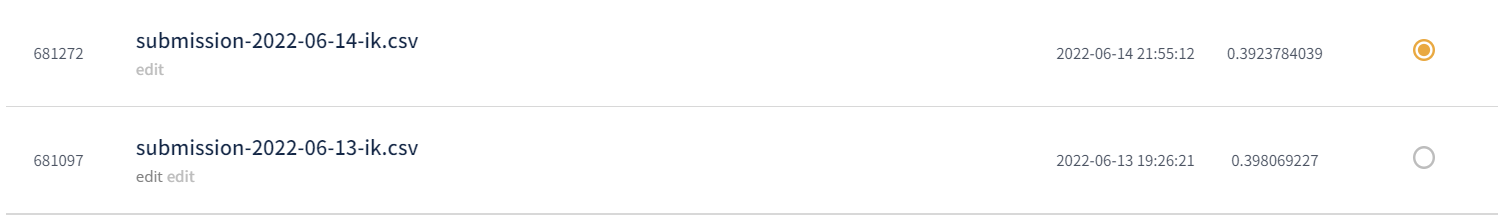